In [1]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
import sys
import os

folder = '../../../../crispy'
print(folder)
if folder not in sys.path: sys.path.append(folder)

from crispy.params import Params
folder = '../../../crispy'
par = Params(folder)

from crispy.tools.initLogger import getLogger
log = getLogger('crispy')
from crispy.IFS import polychromeIFS
from crispy.IFS import reduceIFSMap
from crispy.tools.imgtools import scale2imgs,bowtie
from crispy.tools.image import Image
from crispy.tools.rotate import rotateCube,shiftCube
from crispy.tools.postprocessing import mf,recenter_offaxis
from crispy.tools.inputScene import adjust_krist_header
from crispy.tools.detector import averageDetectorReadout
from astropy.io import fits
import astropy.units as u
from crispy.tools.postprocessing import construct_mflib,convolved_mf


Populating the interactive namespace from numpy and matplotlib
../../../../crispy


In [2]:
lamc=660.
BW = 0.18
par.nonoise=True
sampling=2.0
par.lenslet_sampling=1./sampling
folder = '/Users/mrizzo/IFS/OS5_SIM_'+str(sampling)
offaxis_psf_filename='/Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits'
OS5_files = '/Users/mrizzo/IFS/OS5/with_lowfc/'

try:
    os.makedirs(folder)
    os.makedirs(folder+'/average')
    os.makedirs(folder+'/detector')  
except OSError:
    pass
par.hdr


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                    2 / Interlacing                                    
PHILENS =    26.565051177077

In [3]:
# from crispy.unitTests import testCreateFlatfield
# testCreateFlatfield(par,pixsize=0.1,npix = 512,Nspec=45,pixval = 1.,useQE=True)
# from crispy.IFS import reduceIFSMap
# reduceIFSMap(par,par.unitTestsOutputs+'/flatfield.fits')


In [4]:
from crispy.tools.postprocessing import process_SPC_IFS2

signal, noise = process_SPC_IFS2(par,
                    psf_time_series_folder=OS5_files,
                    offaxis_psf_filename=offaxis_psf_filename,
                    xshift=0.0,yshift=0.0,
                    lamc=lamc,BW=BW,n_ref_star_imgs=30,
                    tel_pupil_area=3.650265060424805*u.m**2,
                    IWA = 3,OWA = 9,
                    pp_fact = 1.00,
                    RDI=False,
                    mflib=folder+'/average/mflib.fits.gz',
                    subtract_ref_psf=True,
                    outdir_time_series = folder,
                    outdir_detector=folder+'/detector',
                    outdir_average=folder+'/average',
                    process_cubes=False, # this only needs to be turned to True once
                    process_offaxis_files=False,
                    process_detector=False,
                    take_averages=False,
                    normalize_contrast=False)

crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/with_lowfc/os5_spc_001.fits
crispy - INFO - X,Y Shift in px in original cubes: 0.00, 0.00
crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/with_lowfc/os5_spc_031.fits
crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_SIM_2.0/average/average_ref_star_detector.fits
crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_SIM_2.0/average/average_ref_star_detector.fits
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ../../../crispy/SimResults/average_ref_star_detector_red_optext.fits
crispy - INFO - Elapsed time: 1.338063s
crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_SIM_2.0/average/average_target_star_detector.fits
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ../../../crispy/SimResults/average_target_star_detector_red_optext.fits
crispy - INFO - Elapsed time: 1.333726s
crispy - INFO - Read data f

In [5]:
signal

array([ 8.90551437,  8.12713847,  7.70201924,  7.69987673,  7.55803115,
        7.58807324,  7.57966628,  7.5324178 ,  7.47290663,  7.57039133,
        7.55870889,  7.60693013,  7.6297361 ,  7.58864261,  7.64097868,
        7.50639017,  7.44648434,  7.44213159,  7.39287449])

In [6]:
noise

[1.0960128672686096,
 0.71837611248544919,
 0.60174708376695152,
 0.56318612453147121,
 0.54863600878319052,
 0.57810027194528468,
 0.61384028132790802,
 0.61444781914520463,
 0.5895771943094742,
 0.57304260428251841,
 0.60950583847643214,
 0.69846377853505914,
 0.80045324888545455,
 0.87016509582849932,
 0.86682410252424835,
 0.82644692780782514,
 0.84917564432405601,
 1.0211213826119732,
 1.2949239768397178]

In [7]:
np.savetxt(folder+"/average/signal.txt",signal)
np.savetxt(folder+"/average/noise.txt",noise)


crispy - INFO - Reduced cube will have 19 wavelength bins


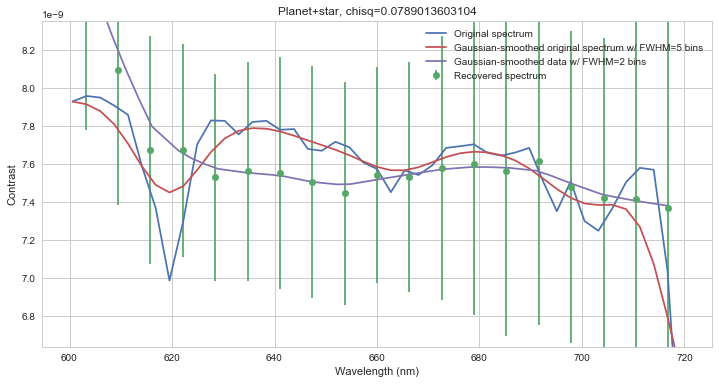

In [8]:
from crispy.tools.postprocessing import SNR_spectrum
from crispy.tools.reduction import calculateWaveList
signal = np.loadtxt(folder+"/average/signal.txt")
noise = np.loadtxt(folder+"/average/noise.txt")
ratio = np.loadtxt(folder+"/average/ratio.txt")
lam_midpts,junk = calculateWaveList(par,method='optext')
wavelist = lamc*np.linspace(1.-BW/2.,1.+BW/2.,45)
ratio_out = SNR_spectrum(lam_midpts,signal,noise,lam_contrast=wavelist,outfolder=par.exportDir+"/",
             FWHM=2*45./19.,FWHMdata=2,edges=1,ymargin=0.05,ratio = None)
#np.savetxt(folder+"/average/ratio.txt",ratio_out)



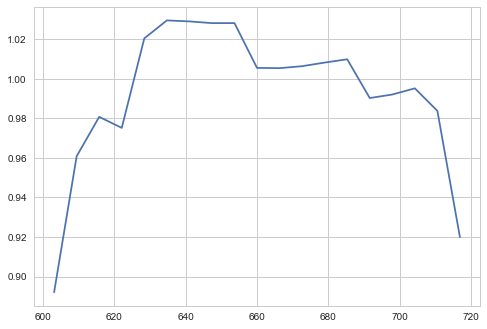

In [9]:
plt.plot(lam_midpts,ratio_out)


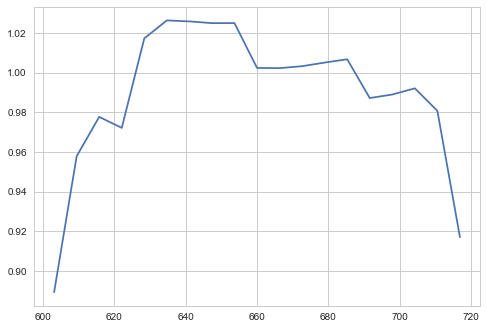

In [10]:
# from crispy.tools.inputScene import calc_contrast_Bijan
plt.plot(lam_midpts,ratio)
# np.savetxt(folder+"/average/ratio.txt",ratio)


<Container object of 3 artists>

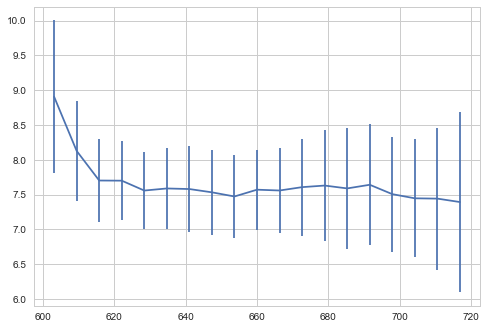

In [11]:
plt.errorbar(lam_midpts,signal,yerr=noise)